# Computer Vision CSCI-GA.2272-001 Assignment 2

## Introduction

This assignment is an introduction to using PyTorch for training simple neural net models. Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

You should perform this assignment in PyTorch, modify this ipython notebook

To install PyTorch, follow instructions at http://pytorch.org/


## Warmup [10%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes
(airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

Use `matplotlib` and ipython notebook's visualization capabilities to display some of these images.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

** Relevant Cell: "Data Loading" **

## Training a Single Layer Network on MNIST [20%]

Start by running the training on MNIST.
By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 50,000 MNIST training images for 10 epochs (passes through the training data). 

The loss function [cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. 
Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

Paste the output into your report.
(a): Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. Grab a screenshot of the figure and include it in your report. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )

(b): Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.

## Training a Multi-Layer Network on MNIST [20%]

- Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class]. Train the model for 10 epochs and save the output into your report.
-  Now set the learning rate to 10 and observe what happens during training. Save the output in your report and give a brief explanation

## Training a Convolutional Network on CIFAR [50%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

Train it for 20 epochs on the CIFAR-10 training set and copy the output
into your report, along with a image of the first layer filters.

Hints: [Follow the first PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) or look at the [MNIST example](https://github.com/pytorch/examples/tree/master/mnist)

- Give a breakdown of the parameters within the above model, and the overall number.

In [120]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [126]:
# options
dataset = 'cifar10' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 20       # number of epochs to train
lr = 0.01        # learning rate

In [127]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the datasets from the internet
if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader2 = torch.utils.data.DataLoader(testset, shuffle=False, num_workers=0)
supx=1


Files already downloaded and verified
Files already downloaded and verified


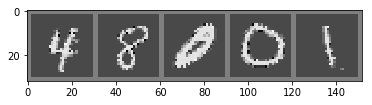

 deer  ship plane plane   car


In [116]:
# classes = ('zero', 'one', 'two', 'three',
#            'four', 'five', 'six', 'seven', 'eight', 'nine')
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
import matplotlib.pyplot as plt
import torchvision
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    beta=np.transpose(npimg, (1, 2, 0))
    plt.imshow(beta)
    plt.show()


# get some random training images
train_loader_for_display = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True, num_workers=0)
dataiter = iter(train_loader_for_display)
images, labels = dataiter.next()
# show images
alpha=torchvision.utils.make_grid(images)
imshow(alpha)
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))


In [107]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [108]:
def train(epoch, break_val):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx==break_val:
            return
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))



In [94]:
for epoch in range(1, epochs + 1):
    train(epoch,60001)
    test()


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.577542
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.544359
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.384140
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.408010
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.373087
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.392287
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.288197
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.288111
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.343845
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.274763

Test set: Average loss: 0.3300, Accuracy: 9067/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.519524
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.337938
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.564827
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.486577
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.195081
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.215729
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.347026
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.244313
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.506253
T

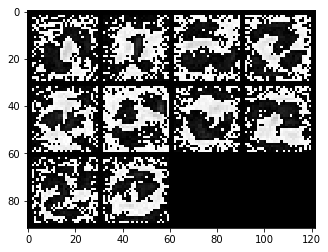

In [95]:
def show(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

img = network.linear.weight.data
img2=img.view(10,1,28,28)
img2.tolist()
show(torchvision.utils.make_grid(img2,nrow=4))


In [109]:
for epoch in range(1, epochs + 1):
    train(epoch,50)
    test()



Train Epoch: 1 [0/60000 (0%)]	Loss: 2.413995

Test set: Average loss: 0.7621, Accuracy: 8260/10000 (83%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.886697

Test set: Average loss: 0.5771, Accuracy: 8578/10000 (86%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.554139

Test set: Average loss: 0.5017, Accuracy: 8714/10000 (87%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.459753

Test set: Average loss: 0.4620, Accuracy: 8817/10000 (88%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.337183

Test set: Average loss: 0.4392, Accuracy: 8861/10000 (89%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.554764

Test set: Average loss: 0.4108, Accuracy: 8912/10000 (89%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.308681

Test set: Average loss: 0.3964, Accuracy: 8928/10000 (89%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.390559

Test set: Average loss: 0.3853, Accuracy: 8952/10000 (90%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.468472

Test set: Average loss: 0.3755, Accuracy: 8979/10000 (90%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.260460


In [117]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, hidden_inputs, num_outputs):
        super(Net, self).__init__()
        self.f1 = nn.Linear(num_inputs, hidden_inputs)
        self.f2 = nn.Linear(hidden_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output1 = F.tanh(self.f1(input))
        output=self.f2(output1)
        return output

network = Net(num_inputs, 1000, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [118]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))




In [119]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test()


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.341428
Train Epoch: 1 [6400/60000 (11%)]	Loss: 643.909790
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1229.932739
Train Epoch: 1 [19200/60000 (32%)]	Loss: 624.699219
Train Epoch: 1 [25600/60000 (43%)]	Loss: 405.776672
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1078.665894
Train Epoch: 1 [38400/60000 (64%)]	Loss: 449.817017
Train Epoch: 1 [44800/60000 (75%)]	Loss: 537.274780
Train Epoch: 1 [51200/60000 (85%)]	Loss: 355.935974
Train Epoch: 1 [57600/60000 (96%)]	Loss: 487.709503

Test set: Average loss: 367.4333, Accuracy: 6858/10000 (69%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 320.170135
Train Epoch: 2 [6400/60000 (11%)]	Loss: 541.442078
Train Epoch: 2 [12800/60000 (21%)]	Loss: 266.904297
Train Epoch: 2 [19200/60000 (32%)]	Loss: 385.677338
Train Epoch: 2 [25600/60000 (43%)]	Loss: 966.936096
Train Epoch: 2 [32000/60000 (53%)]	Loss: 328.864777
Train Epoch: 2 [38400/60000 (64%)]	Loss: 119.439735
Train Epoch: 2 [44800/60000 (75%)]	Loss: 262.330048
Train Epoch: 

In [129]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 128, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(128 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.tanh(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.tanh(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

network = Net()
optimizer = optim.SGD(network.parameters(), lr=lr)

In [130]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))




In [131]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.322038
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.183053
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.148056
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.011059
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.844144
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.968429
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.835537
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.853805

Test set: Average loss: 1.8378, Accuracy: 17830/50000 (36%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.792717
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.825227
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.699355
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.668300
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.876743
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.678932
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.718377
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.808040

Test set: Average loss: 1.6248, Accuracy: 21307/50000 (43%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.637457
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.6


Test set: Average loss: 0.9046, Accuracy: 34295/50000 (69%)

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.768344
Train Epoch: 19 [6400/50000 (13%)]	Loss: 1.172663
Train Epoch: 19 [12800/50000 (26%)]	Loss: 0.951083
Train Epoch: 19 [19200/50000 (38%)]	Loss: 0.825030
Train Epoch: 19 [25600/50000 (51%)]	Loss: 0.737163
Train Epoch: 19 [32000/50000 (64%)]	Loss: 0.984638
Train Epoch: 19 [38400/50000 (77%)]	Loss: 0.993044
Train Epoch: 19 [44800/50000 (90%)]	Loss: 0.780604

Test set: Average loss: 0.8341, Accuracy: 35466/50000 (71%)

Train Epoch: 20 [0/50000 (0%)]	Loss: 0.833307
Train Epoch: 20 [6400/50000 (13%)]	Loss: 1.105089
Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.818836
Train Epoch: 20 [19200/50000 (38%)]	Loss: 0.785232
Train Epoch: 20 [25600/50000 (51%)]	Loss: 0.954037
Train Epoch: 20 [32000/50000 (64%)]	Loss: 0.724312
Train Epoch: 20 [38400/50000 (77%)]	Loss: 0.738534
Train Epoch: 20 [44800/50000 (90%)]	Loss: 0.771691

Test set: Average loss: 0.8010, Accuracy: 36100/50000 (72%)



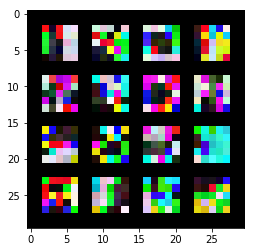

In [278]:
def show(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

img = network.conv1.weight.data
img2=img.view(16,3,5,5)
img2.tolist()
show(torchvision.utils.make_grid(img2,nrow=4))